# Machine Learning - Tarea 3
---

---

<div style="text-align: right">
Vicente Lizana - 201310004-K
</div>
<div style="text-align: right">
Álvaro Valderrama - 201390005-4
</div>

---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbrn
import scipy as sp

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import utils as skut
from sklearn import model_selection as skms
from sklearn import tree as sktr
from sklearn import decomposition as skdc
from sklearn import preprocessing as skpp
from sklearn import svm as sksvm
from sklearn import model_selection as skms
from sklearn import ensemble as skens
from sklearn import metrics as skmt
from sklearn import discriminant_analysis as skda

from keras import models as krms
from keras import layers as krly
from keras import optimizers as kropt
from keras import regularizers as krrg
from keras.utils import np_utils as krnpu

Using TensorFlow backend.


In [2]:
def loading(curr, total):
    loading_string = '['+'='*curr+'>'+' '*(total-1-curr)+'] {:>3d}%'.format(int((curr+1)*100/total))
    loading_string = '\r'*len(loading_string) + loading_string
    print(loading_string, end='')

---

---
## 1.- Small circle inside Large circle

---
### 1.a

#### Generación de Datos

In [45]:
def do_circles(n=2000,noisy_n=0.05):
    generator = skut.check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    
    X = np.vstack((
        np.append(outer_circ_x, inner_circ_x),
        np.append(outer_circ_y, inner_circ_y)
    )).T
    
    y = np.hstack([
        np.zeros(n // 2, dtype=np.intp),
        np.ones(n // 2, dtype=np.intp)
    ])
    
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_test, y_test

In [46]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(12, 8))
    axis.scatter(X_train[:,0], X_train[:,1], s=30, c=Y_train, zorder=10, cmap='cool')
    axis.scatter(X_test[:,0], X_test[:,1], s=20, c=Y_test, zorder=10, cmap='winter')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else:
        raise ValueError('model type not supported')
        
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
    axis.contour(XX, YY, Zplot, alpha=1, colors=["r"], linestyles=["-"], levels=[0.5])
    plt.show()

---
#### Datos:

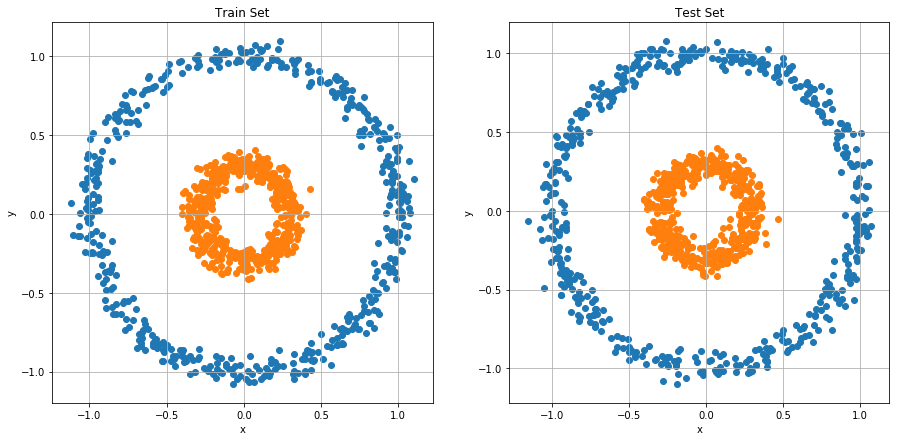

In [47]:
X_train, y_train, X_test, y_test = do_circles()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1])
ax1.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1])
ax1.set_title("Train Set")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1])
ax2.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1])
ax2.set_title("Test Set")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.grid()
plt.show()

---
### 1.b

#### Red con una sola neurona

In [51]:
n_h=1
model = krms.Sequential()
model.add(krly.Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(krly.Dense(n_h, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test, y_test)
test_acc = scores[1]

  32/1000 [..............................] - ETA: 0s

In [52]:
print("Accuracy over Test Set: {:>.3}".format(test_acc))

Accuracy over Test Set: 0.655


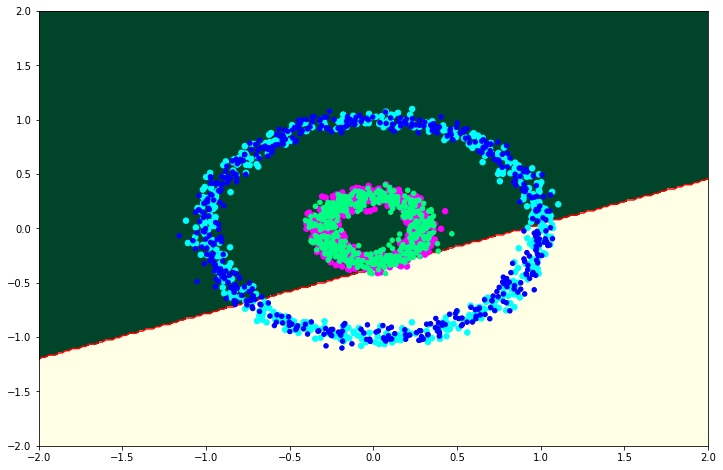

In [53]:
plot_classifier(model, X_train, y_train, X_test, y_test, 'ann')

Vemos que con una sola neurona, la clasificacion se hace mediante separacion por un plano, pues una sola neurona solo puede devolver una combinacion lineal de los datos de entrada, modulada por la funcion de activacion. 



---
#### Cambiando la función de activación:

In [54]:
n_h=1
model = krms.Sequential()
model.add(krly.Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='tanh'))
model.add(krly.Dense(n_h, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test, y_test)
test_acc = scores[1]

  32/1000 [..............................] - ETA: 0s

In [55]:
print("Accuracy over Test Set: {:>.3}".format(test_acc))

Accuracy over Test Set: 0.671


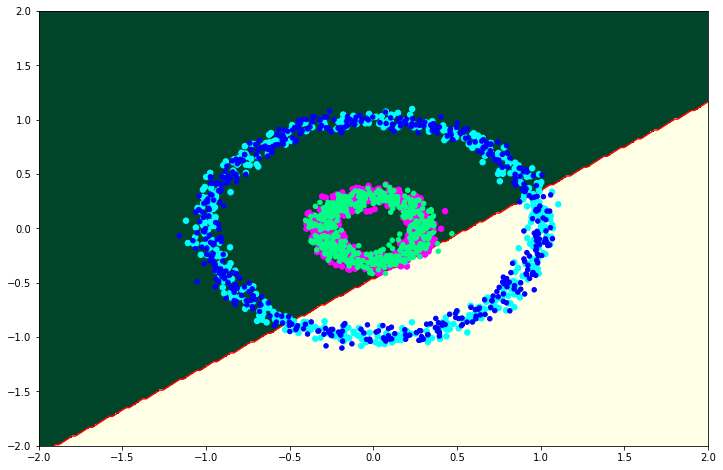

In [56]:
plot_classifier(model, X_train, y_train, X_test, y_test, 'ann')

A pesar que la funcion de activacion es no lineal, ella recibe como input una combinacion lineal. Por lo tanto de todas formas la frontera de decision sera una recta. La data no puede ser clasificada efectivamente por una sola neurona, independiente de la funcion de activacion.

---
### 1.c

#### Red con una _Hidden Layer_, dos neuronas.

In [43]:
n_h=2
model = krms.Sequential()
model.add(krly.Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(krly.Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test, y_test)
test_acc = scores[1]

1000/1000 [==============================] - 0s 108us/step


In [44]:
print(test_acc)

0.869


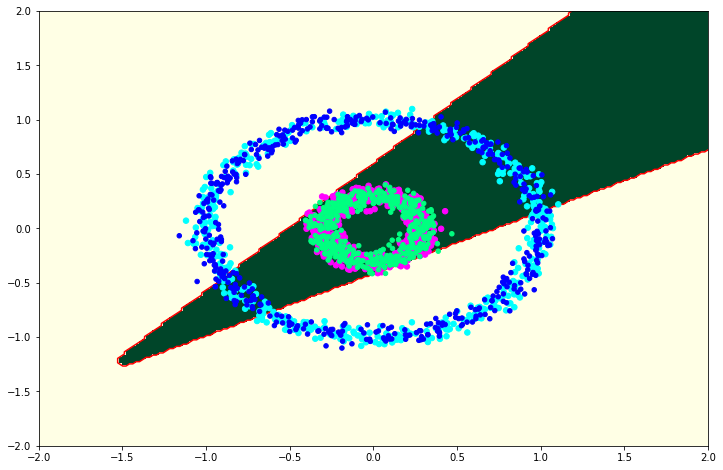

In [45]:
plot_classifier(model, X_train, y_train, X_test, y_test, 'ann')

Con dos neuronas la frontera de desicion se transforma en dos rectas, podemos entender que cada neurona genera una recta de desicion y la interseccion de ambas resulta en la figura del grafico.

---
#### Red con una _Hidden Layer_, 3 neuronas.

In [60]:
n_h=3
model = krms.Sequential()
model.add(krly.Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(krly.Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test, y_test)
test_acc = scores[1]

  32/1000 [..............................] - ETA: 0s

In [61]:
print(test_acc)

1.0


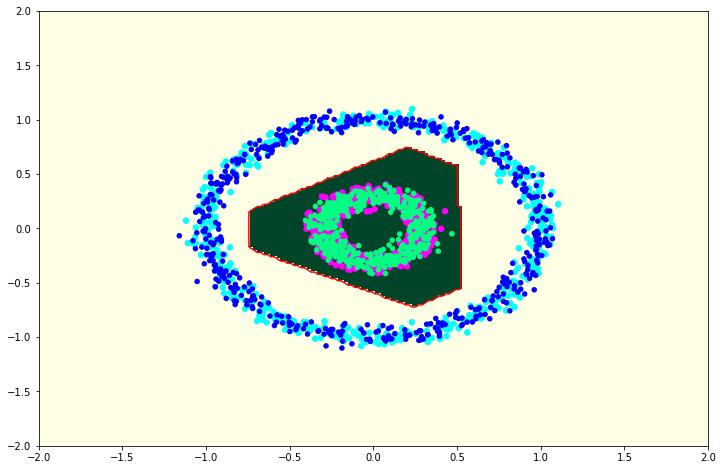

In [62]:
plot_classifier(model, X_train, y_train, X_test, y_test, 'ann')

Ya con tres neuronas usualmente logra clasificar perfectamente la data. La frontera de desicion se complejiza al agregar mas neuronas, y así, puede aproximar mejor cada anillo. 

---
#### Error

In [65]:
errors = []

for n_h in  2 ** np.arange(1,6):
    model = krms.Sequential()
    model.add(krly.Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(krly.Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
    score = model.evaluate(X_test, y_test)
    errors.append(score[0])

  32/1000 [..............................] - ETA: 2s

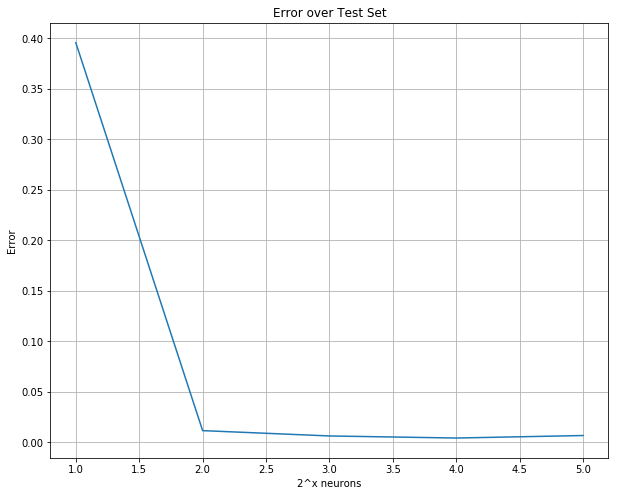

In [66]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(range(1, len(errors) + 1), errors)
ax.set_title("Error over Test Set")
ax.set_ylabel("Error")
ax.set_xlabel("2^x neurons")
ax.grid()
plt.show()

Vemos que mientras el numero de neuronas aumenta el error sobre el test set decrece. Como las redes neuronales no son deterministicas por la inicializacion de los pesos, el grafico no siempre se comporta igual, pero de todas formas para redes suficientemente grande el error siempre es pequeño; es decir la red logra aproximar bien la forma de ambos circulos al usar varias neuronas. Notemos que tambien para muchas neuronas el error tiende a estancarse. Notemos que incluso se puede dar el caso que una red con muchas neuronas, efectivamente anule el efecto de algunas neuronas, tirando sus pesos a cero.

---
### 1.d

#### _Stump_

Test Accuracy = 0.67
Max depth = 1


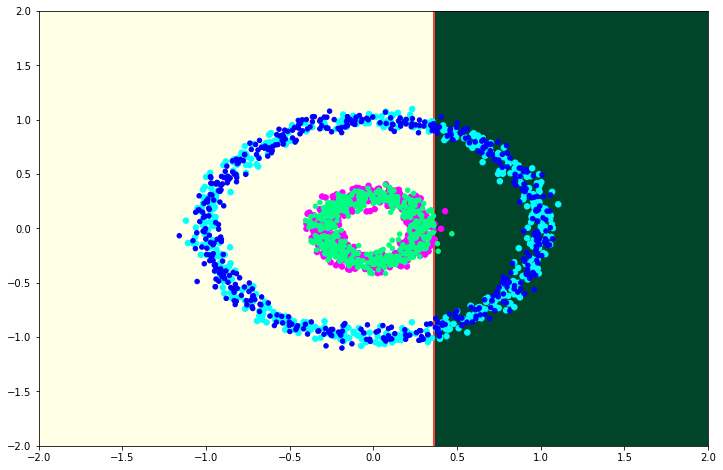

In [54]:
clf = sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=1)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

---
#### Otro intento:

Test Accuracy = 0.679
Max depth = 1


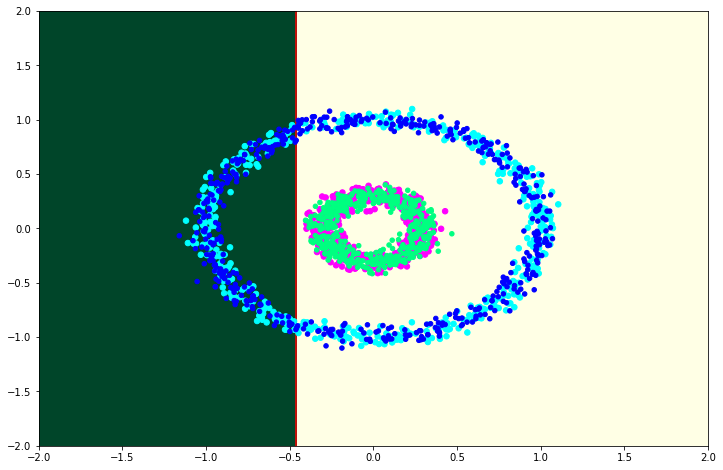

In [57]:
clf = sktr.DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=0, max_depth=1)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

Vemos que en ambos casos, a pesar de cambiar parametros como la forma de elegir el split o el critero, en ningun caso se logra un buen comportamiento. Al tener un solo un nodo, la frontera de desicion solo puede ser una recta paralela a algun eje, por lo tanto jamas lograra representar bien las clases del problema.

---
### 1.e

#### Arbol de Clasificación

Test Accuracy = 0.924
Max depth = 3


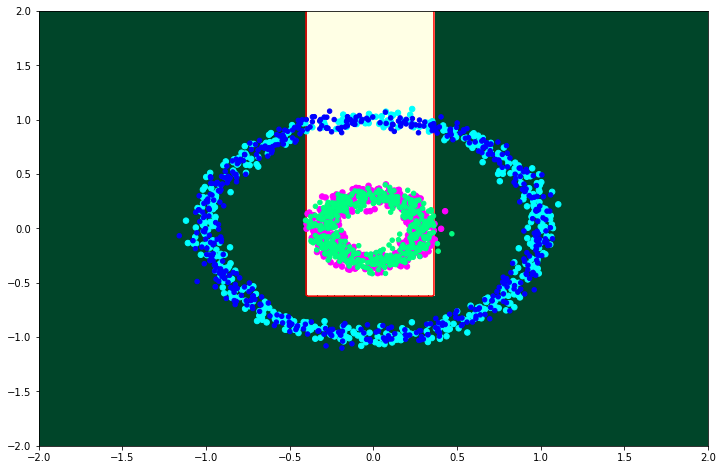

In [58]:
n_t=3
clf=sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=n_t)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

Test Accuracy = 0.994
Max depth = 4


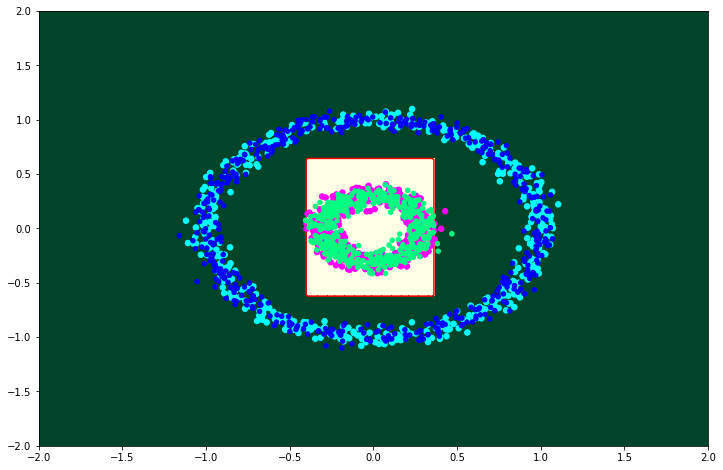

In [59]:
n_t=4
clf=sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=n_t)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

Test Accuracy = 0.992
Max depth = 5


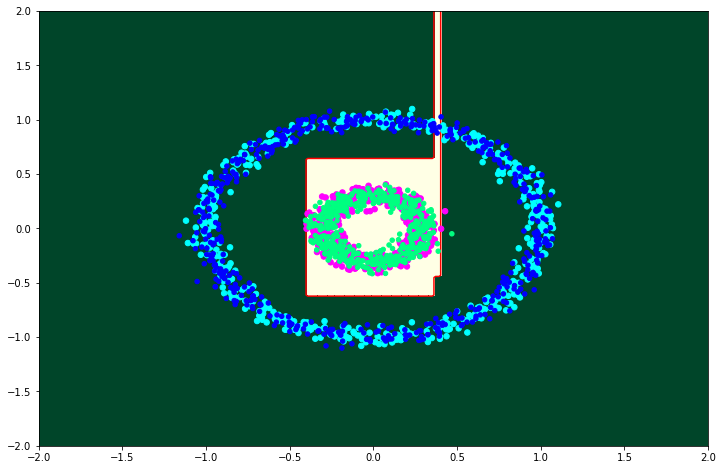

In [67]:
n_t=8
clf=sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=n_t)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

Test Accuracy = 0.997
Max depth = 4


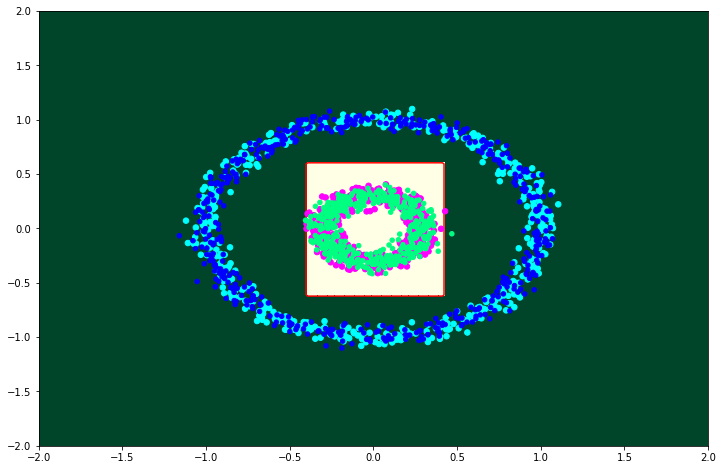

In [71]:
n_t=8
clf=sktr.DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0, max_depth=n_t)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

Al aumentar la profundidad del arbol, la frontera de desicion puede tomar formas mas cercanas a la data. Sin embargo al alumentar mucho la profundidad se tiende al sobre ajuste y la frontera intenta seguir algunos outliers. En algunos casos, cambiando la funcion de penalizacion esto puede sortearse, y el arbol queda con una profundidad maxima menos a la permitida, pero con mejor error de generalizacion. 

---
### 1.f

#### PCA + Kernel Gaussiano

In [72]:
kpca = skdc.KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

Con PCA intentamos de transformar la data hacia un espacio donde pueda ser separada linealmente, como vermos mas adelante, esto se logra para los parametros elegidos pero no es siempre el caso. 

---
### 1.g

#### Separación mediante frontera lineal

Test Accuracy = 1.0
Max depth = 1


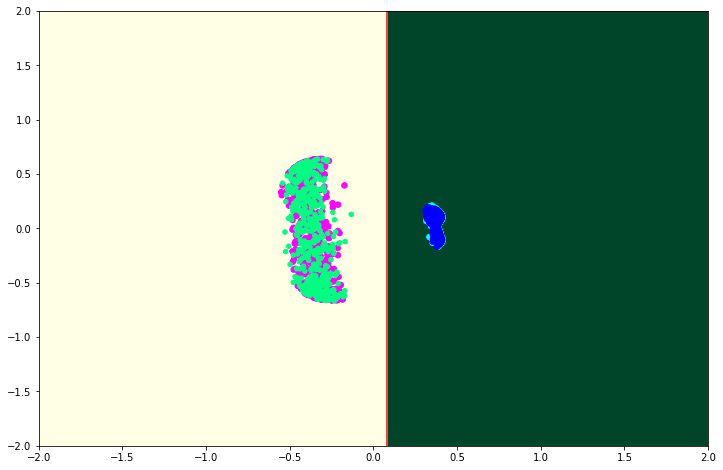

In [74]:
clf = sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=1)
clf.fit(Xkpca_train,y_train)
acc_test = clf.score(Xkpca_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print("Max depth = {}".format(clf.tree_.max_depth))
plot_classifier(clf, Xkpca_train, y_train, Xkpca_test, y_test, 'tree')

Efectivamente, luego de la transformacion la data queda linealmente separable, e incluso un stump logra separar perfectamente la data. 

---

---
## 2.- Bike Sharing

---
### 2.a

#### Carga de Datos

In [85]:
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain, dfval, dftest])
df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


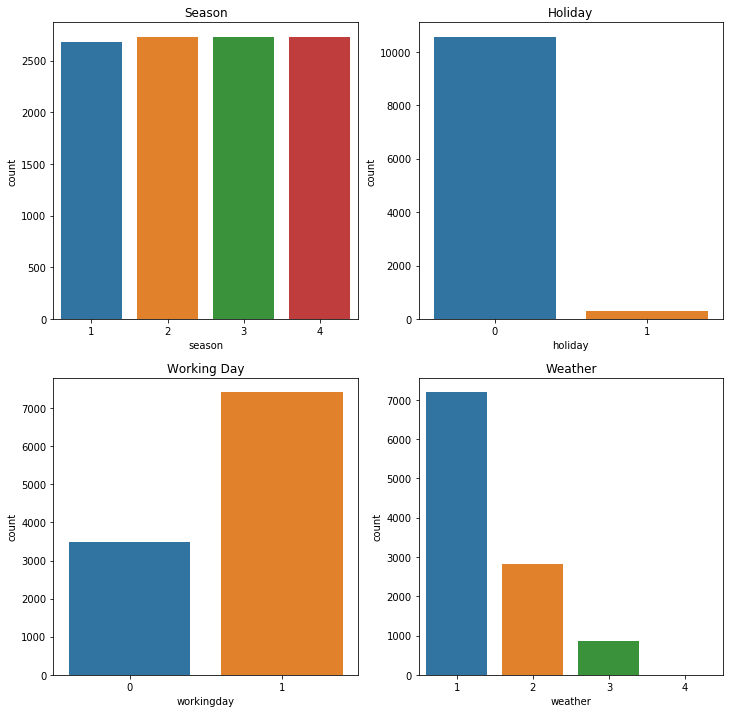

In [4]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.set_title("Season")
sbrn.countplot(x='season', data=df, ax=ax1)

ax2 = fig.add_subplot(222)
ax2.set_title("Holiday")
sbrn.countplot(x='holiday', data=df, ax=ax2)

ax3 = fig.add_subplot(223)
ax3.set_title("Working Day")
sbrn.countplot(x='workingday', data=df, ax=ax3)

ax4 = fig.add_subplot(224)
ax4.set_title("Weather")
sbrn.countplot(x='weather', data=df, ax=ax4)

plt.show()

Si bien vemos que algunas clases de la data estan desbalanceadas, esto parece normal considerando la informacion que representa, por ejemplo los climas mas inusuales como nieve o tormenta tienen pocos casos. Sin embargo eso no quiere decir que estos casos sean poco significativos, al contrario puede resultar que esa informacion este fuertemente correlacionada con el target. 

In [5]:
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])
df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


---
### 2.b

#### Arbol de Regresión

In [6]:
def eval_bikemodel(y_predict, y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def plot_predictions(y_predict, y_true, model=''):
    plt.figure(figsize=(7,7))
    plt.plot(y_true, y_predict, '.')
    plt.plot((0,1000), (0,1000), 'r')
    plt.title('Predictions ' + model)
    plt.xlabel('real y')
    plt.ylabel('predicted y')
    plt.grid()
    plt.show()

     SCORE TEST = 0.7033880538
KAGG EVAL TRAIN = 0.0285162833
KAGG EVAL VAL   = 0.5545114263
 KAGG EVAL TEST = 0.5742388006


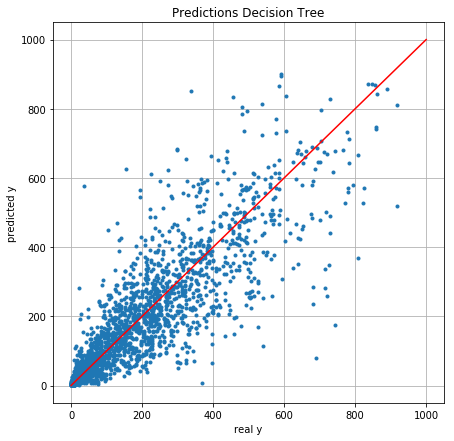

In [39]:
Xdf = df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf = df.loc[:,'count']
X_train_2 = Xdf[0:ntrain].values
X_val_2 = Xdf[ntrain:nval].values
X_test_2 = Xdf[nval:].values
Y_train_2 = Ydf[0:ntrain].values
Y_val_2 = Ydf[ntrain:nval].values
Y_test_2 = Ydf[nval:].values

model = sktr.DecisionTreeRegressor(random_state=0)
model.fit(X_train_2,Y_train_2)
score_test_2 = model.score(X_test_2,Y_test_2)
print("     SCORE TEST = {:>.10f}".format(score_test_2))

Y_pred_train_2 = model.predict(X_train_2)
Y_pred_val_2 = model.predict(X_val_2)
Y_pred_test_2 = model.predict(X_test_2)
kagg_train_2 = eval_bikemodel(Y_pred_train_2,Y_train_2)
kagg_val_2 = eval_bikemodel(Y_pred_val_2,Y_val_2)
kagg_test_2 = eval_bikemodel(Y_pred_test_2,Y_test_2)
print("KAGG EVAL TRAIN = {:>.10f}".format(kagg_train_2))
print("KAGG EVAL VAL   = {:>.10f}".format(kagg_val_2))
print(" KAGG EVAL TEST = {:>.10f}".format(kagg_test_2))

plot_predictions(Y_test_2, Y_pred_test_2, model='Decision Tree')

Vemos que con un solo arbol de regresion con los parametros por default el desempeño no es demasiado bueno. Procedemos a buscar Hiperparametros que mejoren el desempeño. 

---
### 2.c

#### _Tunning_ de Hiperparámetros

In [8]:
errors_tree_max_depth_2_tr = []
errors_tree_max_depth_2_v = []
errors_tree_max_depth_2_t = []
for i in range(1,31):
    model = sktr.DecisionTreeRegressor(random_state=0, max_depth=i, splitter='random')
    model.fit(X_train_2, Y_train_2)
    
    Y_pred_train = model.predict(X_train_2)
    kagg_val = eval_bikemodel(Y_pred_train, Y_train_2)
    errors_tree_max_depth_2_tr.append(kagg_val)
    
    Y_pred_val = model.predict(X_val_2)
    kagg_val = eval_bikemodel(Y_pred_val, Y_val_2)
    errors_tree_max_depth_2_v.append(kagg_val)
    
    Y_pred_test = model.predict(X_test_2)
    kagg_val = eval_bikemodel(Y_pred_test, Y_test_2)
    errors_tree_max_depth_2_t.append(kagg_val)

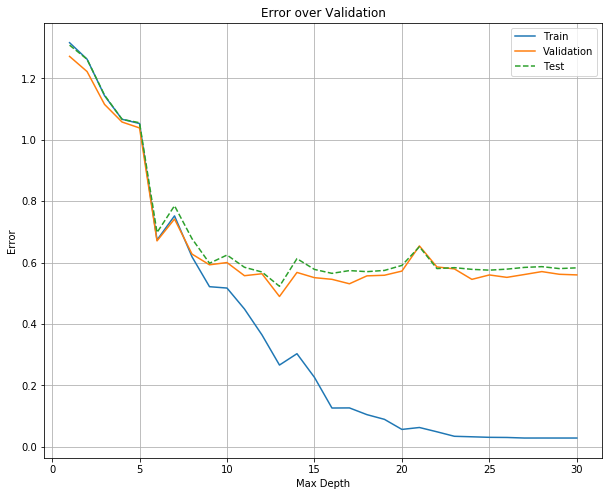

In [9]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(range(1,31), errors_tree_max_depth_2_tr, label='Train')
ax.plot(range(1,31), errors_tree_max_depth_2_v, label='Validation')
ax.plot(range(1,31), errors_tree_max_depth_2_t, '--', label='Test')
ax.grid()
ax.set_title("Error over Validation")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Error")
ax.legend()
plt.show()

---

In [10]:
errors_tree_max_depth_2_tr = []
errors_tree_max_depth_2_v = []
errors_tree_max_depth_2_t = []
for i in range(1,31):
    model = sktr.DecisionTreeRegressor(random_state=0, max_depth=i)
    model.fit(X_train_2, Y_train_2)
    
    Y_pred_train = model.predict(X_train_2)
    kagg_val = eval_bikemodel(Y_pred_train, Y_train_2)
    errors_tree_max_depth_2_tr.append(kagg_val)
    
    Y_pred_val = model.predict(X_val_2)
    kagg_val = eval_bikemodel(Y_pred_val, Y_val_2)
    errors_tree_max_depth_2_v.append(kagg_val)
    
    Y_pred_test = model.predict(X_test_2)
    kagg_val = eval_bikemodel(Y_pred_test, Y_test_2)
    errors_tree_max_depth_2_t.append(kagg_val)

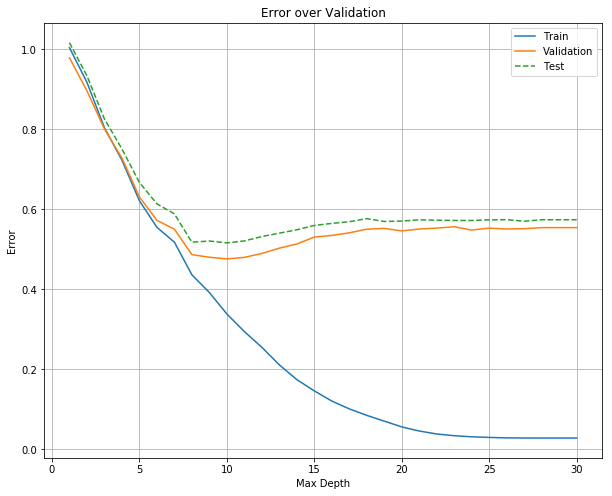

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(range(1,31), errors_tree_max_depth_2_tr, label='Train')
ax.plot(range(1,31), errors_tree_max_depth_2_v, label='Validation')
ax.plot(range(1,31), errors_tree_max_depth_2_t, '--', label='Test')
ax.grid()
ax.set_title("Error over Validation")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Error")
ax.legend()
plt.show()

En una primera busqueda vemos cual es la profundidad maxima del arbol optima. Notemos que la curva de sobreajuste es mas suave al cambiar el criterio de eleccion de la frontera de desicion de random a best (que viene por default). Esto tiene sentido pues la eleccion por random best tiene inherentemente mas variabilidad. 

---

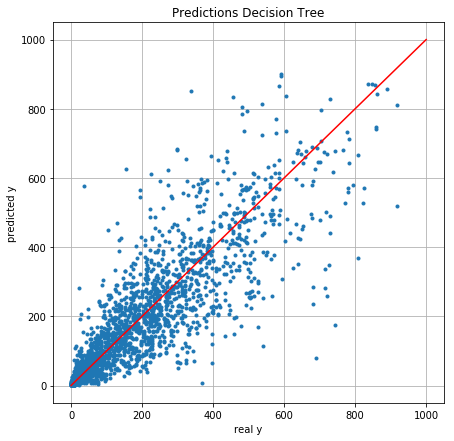

 KAGG EVAL VALIDATION = 0.4762735846
 KAGG EVAL TEST = 0.5163963473


In [12]:
best = np.argmin(errors_tree_max_depth_2_v)
model = sktr.DecisionTreeRegressor(random_state=0, max_depth=best+1)
model.fit(X_train_2, Y_train_2)
Y_pred_val = model.predict(X_val_2)
kagg_val = eval_bikemodel(Y_pred_val, Y_val_2)
Y_pred_val = model.predict(X_test_2)
kagg_test = eval_bikemodel(Y_pred_val, Y_test_2)
plot_predictions(Y_test_2, Y_pred_test, model='Decision Tree')
print(" KAGG EVAL VALIDATION = {:>.10f}".format(kagg_val))
print(" KAGG EVAL TEST = {:>.10f}".format(kagg_test))

Efectivamente al tomar la profundidad maxima optima el desempeño mejora sobre el set de validacion. 

---
### 2.d

#### _Tunning_ de la Representación

In [13]:
def qqplot_target(y):
    fig = plt.figure(figsize=(14, 14))
    axes = []
    for i in range(1,10):
        axes.append(fig.add_subplot(3, 3, i))
        sp.stats.probplot(y ** (i/10), dist=sp.stats.norm, plot=axes[-1])
        axes[-1].set_title("Q-Q {}".format(i/10))
        axes[-1].grid()

    plt.show()

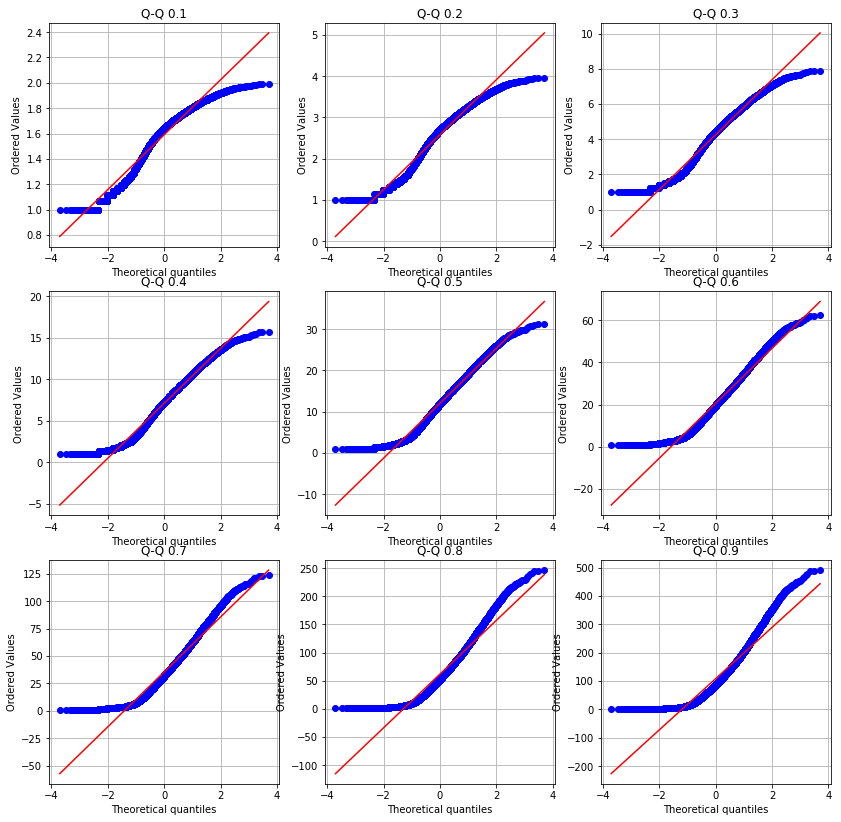

In [14]:
qqplot_target(Y_train_2)

Los QQ-plot sugieren una tranformacion de la data que podría ser util. Procedemos a transformar la data elevandola a 0.6 para luego entrenar el modelo con esta nueva data. 

In [15]:
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek # 0:lunes, 6:domingo
df['cday'] = pd.to_numeric(df['cday'])

df['day'] = pd.to_datetime(df['datetime']).dt.day
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['year'] = pd.to_datetime(df['datetime']).dt.year

Xdf = df.loc[:,['holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','day','month','year']]

new_X_train_2 = Xdf[0:ntrain].values
new_X_val_2 = Xdf[ntrain:nval].values
new_X_test_2 = Xdf[nval:].values
new_Y_train_2 = Y_train_2 ** (3/5)
new_Y_val_2 = Y_val_2 ** (3/5)
new_Y_test_2 = Y_test_2 ** (3/5)
Xdf.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,cday,day,month,year
0,0,0,1,9.84,14.395,75,0.0000,3,5,1,1,2011
1,0,0,1,9.84,14.395,75,0.0000,4,5,1,1,2011
2,0,0,2,9.84,12.880,75,6.0032,5,5,1,1,2011
3,0,0,1,9.02,13.635,80,0.0000,6,5,1,1,2011
4,0,0,1,8.20,12.880,86,0.0000,7,5,1,1,2011


In [16]:
def new_eval_bikemodel(y_predict, y_true):
#     diff = np.log(y_predict**2+1.0) - np.log(y_true**2+1.0)
    diff = np.log(y_predict**(5/3)+1.0) - np.log(y_true**(5/3)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def new_plot_predictions(y_predict, y_true, model=''):
    plt.figure(figsize=(7,7))
#     plt.plot(y_true**2, y_predict**2, '.')
    plt.plot(y_true**(5/3), y_predict**(5/3), '.')
    plt.plot((0,1000), (0,1000), 'r')
    plt.title('Predictions ' + model)
    plt.xlabel('real y')
    plt.ylabel('predicted y')
    plt.grid()
    plt.show()

---

In [17]:
errors_tree_max_depth_2_tr = []
errors_tree_max_depth_2_v = []
errors_tree_max_depth_2_t = []
for i in range(1,31):
    model = sktr.DecisionTreeRegressor(random_state=0, max_depth=i)
    model.fit(new_X_train_2, new_Y_train_2)
    
    Y_pred_train = model.predict(new_X_train_2)
    kagg_val = new_eval_bikemodel(Y_pred_train, new_Y_train_2)
    errors_tree_max_depth_2_tr.append(kagg_val)
    
    Y_pred_val = model.predict(new_X_val_2)
    kagg_val = new_eval_bikemodel(Y_pred_val, new_Y_val_2)
    errors_tree_max_depth_2_v.append(kagg_val)
    
    Y_pred_test = model.predict(new_X_test_2)
    kagg_val = new_eval_bikemodel(Y_pred_test, new_Y_test_2)
    errors_tree_max_depth_2_t.append(kagg_val)

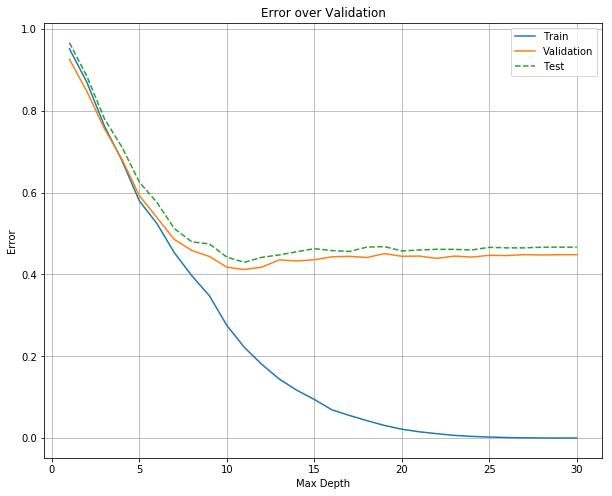

In [18]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(range(1,31), errors_tree_max_depth_2_tr, label='Train')
ax.plot(range(1,31), errors_tree_max_depth_2_v, label='Validation')
ax.plot(range(1,31), errors_tree_max_depth_2_t, '--', label='Test')
ax.grid()
ax.set_title("Error over Validation")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Error")
ax.legend()
plt.show()

---

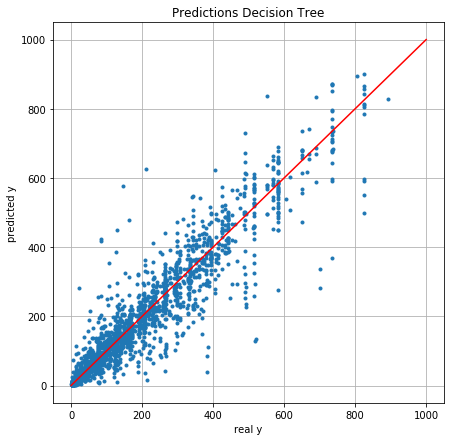

 KAGG EVAL VALIDATION = 0.4121892820
 KAGG EVAL TEST = 0.4297994122


In [75]:
best = np.argmin(errors_tree_max_depth_2_v)
model = sktr.DecisionTreeRegressor(random_state=0, max_depth=best+1)
model.fit(new_X_train_2, new_Y_train_2)
Y_pred_val = model.predict(new_X_val_2)
kagg_val = new_eval_bikemodel(Y_pred_val, new_Y_val_2)
Y_pred_test = model.predict(new_X_test_2)
kagg_test = new_eval_bikemodel(Y_pred_test, new_Y_test_2)
new_plot_predictions(new_Y_test_2, Y_pred_test, model='Decision Tree')
print(" KAGG EVAL VALIDATION = {:>.10f}".format(kagg_val))
print(" KAGG EVAL TEST = {:>.10f}".format(kagg_test))

Nuevamente vemos que el error sobre el validation mejora. La transformacion de la data es efectivamente util para entrenar esta maquina en particular. 

---
### 2.e

#### SVM no lineal

In [20]:
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')

In [21]:
def new_new_eval_bikemodel(y_predict, y_true):
    diff = np.log(np.e**y_predict+1.0) - np.log(np.e**y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def new_new_plot_predictions(y_predict, y_true, model=''):
    plt.figure(figsize=(7,7))
    plt.plot(np.e**y_true, np.e**y_predict, '.')
    plt.plot((0,1000), (0,1000), 'r')
    plt.title('Predictions ' + model)
    plt.xlabel('real y')
    plt.ylabel('predicted y')
    plt.grid()
    plt.show()

In [22]:
df = pd.concat([dftrain, dfval, dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])

df['day'] = pd.to_datetime(df['datetime']).dt.day
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['year'] = pd.to_datetime(df['datetime']).dt.year

Xdf = df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','day','month','year']]
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday','day','month','year'])
Ydf=df.loc[:,'count']

X_train_2 = Xdf[0:ntrain].values
X_val_2 = Xdf[ntrain:nval].values
X_test_2 = Xdf[nval:].values

Y_train_2 = np.log(Ydf[0:ntrain].values)
Y_val_2 = np.log(Ydf[ntrain:nval].values)
Y_test_2 = np.log(Ydf[nval:].values)

Xdf.head()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
0,0,0,9.84,14.395,75,0.0000,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,9.84,14.395,75,0.0000,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,9.84,12.880,75,6.0032,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,9.02,13.635,80,0.0000,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,8.20,12.880,86,0.0000,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
scalerX = skpp.StandardScaler()
X_train_2 = scalerX.fit_transform(X_train_2)
X_val_2 = scalerX.fit_transform(X_val_2)
X_test_2 = scalerX.transform(X_test_2)

model = sksvm.SVR()
model.fit(X_train_2,Y_train_2)

Y_pred_train_2 = model.predict(X_train_2)
Y_pred_val_2 = model.predict(X_val_2)
Y_pred_test_2 = model.predict(X_test_2)

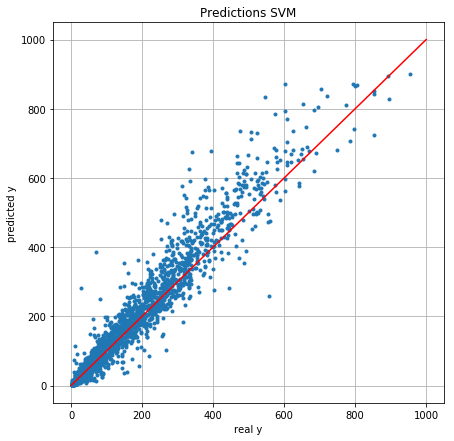

 KAGG EVAL VALIDATION = 0.3085455357
 KAGG EVAL TEST = 0.3364678330


In [24]:
new_new_plot_predictions(Y_test_2, Y_pred_test_2, model='SVM')
kagg_val = new_new_eval_bikemodel(Y_pred_val_2, Y_val_2)
kagg_test = new_new_eval_bikemodel(Y_pred_test_2, Y_test_2)
print(" KAGG EVAL VALIDATION = {:>.10f}".format(kagg_val))
print(" KAGG EVAL TEST = {:>.10f}".format(kagg_test))

Para entrenar la SVM tranformamos los inputs categoricos a vectores y tranformamos los targets mediante un logaritmo. En este caso, obtenemos un error de validacion mucho mejor que en los modelos anteriores. 

---
### 2.f

#### _Tunning_ de Hiperparámetros

In [25]:
svr_cs = np.linspace(0.2, 2, 10)
svr_epsilons = np.linspace(0.02, 0.2, 10)

plot_x, plot_y = np.meshgrid(svr_cs, svr_epsilons)
scores_svr = np.zeros(plot_x.shape)

best_score = 1
best_i = 0
best_j = 0
for i in range(len(svr_cs)):
    for j in range(len(svr_epsilons)):
        model = sksvm.SVR(C=svr_cs[i],epsilon=svr_epsilons[j])
        model.fit(X_train_2,Y_train_2)
        Y_pred_val_2 = model.predict(X_val_2)
        scores_svr[i,j] = new_new_eval_bikemodel(Y_pred_val_2,Y_val_2)
        if scores_svr[i,j] < best_score:
            best_score = scores_svr[i,j]
            best_i = i
            best_j = j
        loading(i*len(svr_cs)+j, len(svr_cs)*len(svr_epsilons))

[===================================================================================================>] 100%

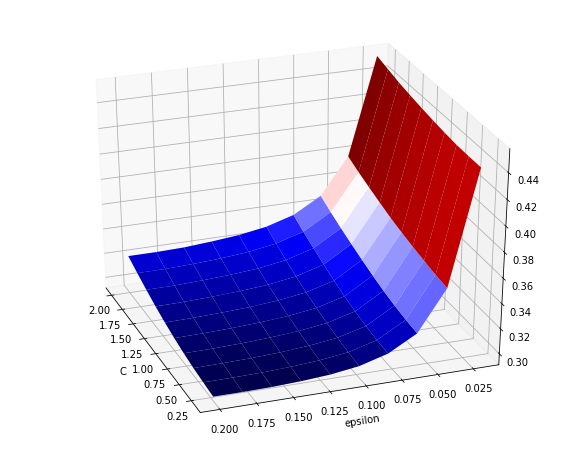

In [76]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.view_init(30, 160)
ax.plot_surface(plot_x, plot_y, scores_svr, cmap='seismic')
ax.set_xlabel('C')
ax.set_ylabel('epsilon')
plt.show()

Hacemos un grid-search sobre los parametros C y epsilon y vemos efectivamente que el error decrece en algunas direcciones. Procedemos a hacer un segundo gridsearch partiendo desde el punto minimal del anterior y encontramos un optimo local, donde variaciones en los parametros practicamente no tienen influencia sobre el error. Obtuvimos C=1.95 y epsilon=0.0001.

---
### 2.g

#### _K-Folds_

In [27]:
kf = skms.KFold(n_splits=5)
Xm = np.vstack([X_train_2, X_val_2])
ym = np.hstack([Y_train_2, Y_val_2])

srv_cs = [1.9, 1.95, 2]
srv_epsilon = [0.00005, 0.0001, 0.00015]
new_scores_svr = np.zeros((3,3))

l = 0
for i in range(3):
    for j in range(3):
        mse_cv = []
        for train, val in kf.split(Xm):
            model = sksvm.SVR(C=1.95, epsilon=0.0001)
            model.fit(Xm[train], ym[train])
            yhat_val = model.predict(Xm[val])
            ytrue_val = ym[val]
            score_fold = new_new_eval_bikemodel(yhat_val,ytrue_val)
            mse_cv.append(score_fold)
            loading(l, 45)
            l += 1
        new_scores_svr[i,j] = np.mean(mse_cv)

[============================================>] 100%

In [77]:
new_scores_svr

array([[ 0.31150087,  0.31150087,  0.31150087],
       [ 0.31150087,  0.31150087,  0.31150087],
       [ 0.31150087,  0.31150087,  0.31150087]])

Usamos 5-fold en todos los valores proximales de los hiperparametros elegidos. Vemos que el error promedio es igual para todos los casos. Interpretamos esto como un error con derivada cero respecto a los parametros, es decir efectivamente hemos alcanzado un minimo. 

---
### 2.h

#### Ensamblado de dos Máquinas

In [86]:
Ydf_count = df.loc[:,'count'] # demanda total
Ydf_reg = df.loc[:,'registered'] # demanda registrada
Ydf_cas = df.loc[:,'casual'] # demanda casual

Y_train_2_count = np.log(Ydf_count[:ntrain].values+0.01)
Y_val_2_count = np.log(Ydf_count[ntrain:nval].values+0.01)
Y_test_2_count = np.log(Ydf_count[nval:].values+0.01)

Y_train_2_reg = np.log(Ydf_reg[:ntrain].values+0.01)
Y_val_2_reg = np.log(Ydf_reg[ntrain:nval].values+0.01)
Y_test_2_reg = np.log(Ydf_reg[nval:].values+0.01)

Y_train_2_cas = np.log(Ydf_cas[:ntrain].values+0.01)
Y_val_2_cas = np.log(Ydf_cas[ntrain:nval].values+0.01)
Y_test_2_cas = np.log(Ydf_cas[nval:].values+0.01)

---

In [87]:
model_reg = sksvm.SVR()
model_reg.fit(X_train_2,Y_train_2_reg)
Y_pred_val_reg_2 = model_reg.predict(X_val_2)
reg_score = eval_bikemodel(np.e ** Y_pred_val_reg_2 - 0.01, np.e ** Y_val_2_reg - 0.01)

model_cas = sksvm.SVR()
model_cas.fit(X_train_2,Y_train_2_cas)
Y_pred_val_cas_2 = model_cas.predict(X_val_2)
cas_score = eval_bikemodel(np.e ** Y_pred_val_cas_2 - 0.01, np.e ** Y_val_2_cas - 0.01)

print("Registrated score: {}".format(reg_score))
print("     Casual score: {}".format(cas_score))

Registrated score: 0.8810640712476222
     Casual score: 0.8892926069876337


In [88]:
def join_m(y_cas, y_reg):
    return (np.e ** y_cas) + (np.e ** y_reg) - 0.02

In [89]:
Y_pred_val_2 = join_m(Y_pred_val_reg_2, Y_pred_val_cas_2)
print("Count score: {}".format(eval_bikemodel(Y_pred_val_2, (np.e ** Y_val_2) - 0.01)))

Count score: inf


C:\Users\runo\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


Al hacer una combinacion de dos maquinas entrenadas separadamente para los usuarios registrados y los usuarios casuales para prpedecir el total de usuarios obtenemos el mejor score que hemos tenido hasta ahora. 

---
### 2.i

#### Algoritmo Genérico

In [91]:
X_train_2 = Xdf[0:ntrain].values
X_val_2 = Xdf[ntrain:nval].values
X_test_2 = Xdf[nval:].values

Y_train_2 = Ydf[0:ntrain].values ** (3/5)
Y_val_2 = Ydf[ntrain:nval].values ** (3/5)
Y_test_2 = Ydf[nval:].values ** (3/5)

[====================================================================================================>] 101%

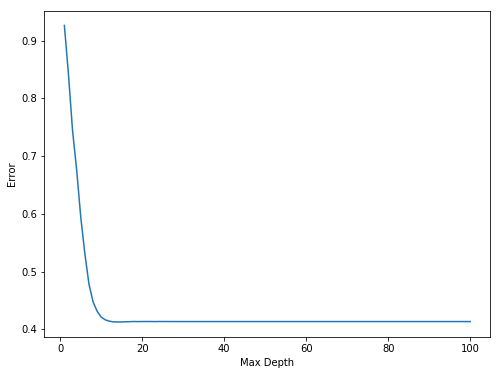

In [92]:
err_test_max_depth_val = []
for i in range(1,101):
    max_depth = i
    model = skens.RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=0)
    model.fit(X_train_2, Y_train_2)
    y_pred_val_2 = model.predict(X_val_2)
    err_val = new_eval_bikemodel(y_pred_val_2, Y_val_2)
    err_test_max_depth_val.append(err_val)
    loading(i, 100)

plt.figure(figsize=(8,6))
plt.plot(range(1,101), err_test_max_depth_val)
plt.grid()
plt.xlabel("Max Depth")
plt.ylabel("Error")
plt.grid()
plt.show()

In [95]:
max_depth = np.argmin(err_test_max_depth_val) + 1
model = skens.RandomForestRegressor(n_estimators=1500, max_depth=max_depth, random_state=0)
model.fit(X_train_2, Y_train_2)
y_pred_val_2 = model.predict(X_val_2)
err_val = new_eval_bikemodel(y_pred_val_2, Y_val_2)
y_pred_test_2 = model.predict(X_test_2)
err_test = new_eval_bikemodel(y_pred_test_2, Y_test_2)
print("Max Depth: {}".format(np.argmin(err_test_max_depth_val) + 1))
print("Validation Error: {}".format(err_val))
print("      Test Error: {}".format(err_test))

Max Depth: 14
Validation Error: 0.41255211212558307
      Test Error: 0.4441172143563833


Al hacer un random forest con la profundidad maxima optima obtenida obtenemos resultados mejores que con modelos iniciales, sin embargo no vence al mejor modelo hasta el momento.  

In [40]:
model.feature_importances_

array([ 0.04118403,  0.00479538,  0.08005592,  0.02536423,  0.12763658,
        0.02357383,  0.06765909,  0.03557286,  0.59415807])

In [42]:
X.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour
0,1,0,0,1,9.84,14.395,75,0.0000,3
1,1,0,0,1,9.84,14.395,75,0.0000,4
2,1,0,0,2,9.84,12.880,75,6.0032,5
3,1,0,0,1,9.02,13.635,80,0.0000,6
4,1,0,0,1,8.20,12.880,86,0.0000,7


---

---
## 3.- Calidad de un Vino

---
### 3.a

#### Datos

In [53]:
df_3_red = pd.read_csv("winequality-red.csv",sep=";")
df_3_red['type'] = [1 for i in range(df_3_red.shape[0])]
df_3_white = pd.read_csv("winequality-white.csv",sep=";")
df_3_white['type'] = [0 for i in range(df_3_white.shape[0])]
df_3 = pd.concat([df_3_red,df_3_white], axis=0)

df_3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [54]:
df_3.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,0


---
### 3.b

#### Preparación de los Datos

In [67]:
df_3['good_quality'] = [1 if q > 5 else 0 for q in df_3.quality]
df_3_data = df_3.drop(['good_quality', 'quality'], axis=1)
df_3_target = df_3['good_quality']

X_train_3, X_test_3, y_train_3, y_test_3 = skms.train_test_split(df_3_data, df_3_target, test_size=0.25)
X_train_3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
218,5.7,0.28,0.24,17.5,0.044,60.0,167.0,0.99890,3.31,0.44,9.4,0
3662,6.1,0.60,0.12,1.8,0.050,11.0,76.0,0.99268,3.42,0.48,10.4,0
1881,7.2,0.20,0.61,16.2,0.043,14.0,103.0,0.99870,3.06,0.36,9.2,0
1218,7.2,0.26,0.44,7.1,0.027,25.0,126.0,0.99300,3.02,0.34,11.1,0
443,10.0,0.44,0.49,2.7,0.077,11.0,19.0,0.99630,3.23,0.63,11.6,1


Se elimina también la columna `'quality'` ya que la utilizamos para la extracción de `'good_quality'`, si no la eliminamos el _learner_ podría simplemente aprender a fijarse si es mayor a 5 para obtener el _target_.

---

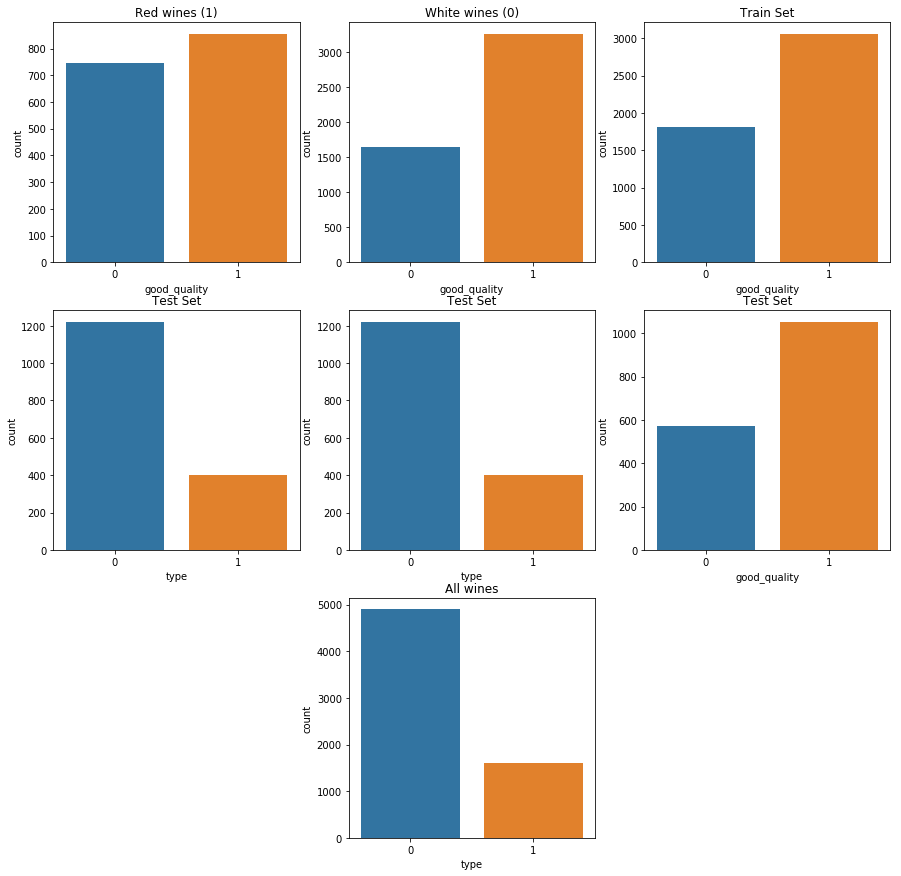

In [70]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(331)
ax1.set_title("Red wines (1)")
sbrn.countplot(x='good_quality', data=df_3[df_3['type'] == 1], ax=ax1)

ax2 = fig.add_subplot(332)
ax2.set_title("White wines (0)")
sbrn.countplot(x='good_quality', data=df_3[df_3['type'] == 0], ax=ax2)

X_train_3_full = pd.DataFrame(X_train_3)
X_train_3_full['good_quality'] = y_train_3
ax3 = fig.add_subplot(333)
ax3.set_title("Train Set")
sbrn.countplot(x='good_quality', data=X_train_3_full, ax=ax3)
X_train_3 = X_train_3.drop('good_quality', axis=1)

ax4 = fig.add_subplot(334)
ax4.set_title("Test Set")
sbrn.countplot(x='type', data=X_test_3_full, ax=ax4)

ax5 = fig.add_subplot(335)
ax5.set_title("Test Set")
sbrn.countplot(x='type', data=X_test_3_full, ax=ax5)

X_test_3_full = pd.DataFrame(X_test_3)
X_test_3_full['good_quality'] = y_test_3
ax6 = fig.add_subplot(336)
ax6.set_title("Test Set")
sbrn.countplot(x='good_quality', data=X_test_3_full, ax=ax6)
X_test_3 = X_test_3.drop('good_quality', axis=1)

ax7 = fig.add_subplot(338)
ax7.set_title("All wines")
sbrn.countplot(x='type', data=df_3, ax=ax7)

plt.show()

Podemos ver que las clases no están equi-representadas en cuanto a tipo de vino, y en el caso de vino blanco también existe un desbalance (aunque no tan relevante) en cuanto a calidad, lo que justifica utilizar el $F_1$-score.

---
### 3.c

#### Arbol de Clasificación

In [74]:
model = sktr.DecisionTreeClassifier()
model.fit(X_train_3, y_train_3)
y_pred_3 = model.predict(X_test_3)
f1_tree_3 = skmt.f1_score(y_test_3, y_pred_3)
print("F1-score Decision Tree: {:>.3}".format(f1_tree_3))

F1-score Decision Tree: 0.813


---
### 3.d

#### Random Forest

In [103]:
scores_md5_train = []
scores_md5_test = []
total = 100
for n in range(total):
    model = skens.RandomForestClassifier(n_estimators=n+1, max_depth=5, n_jobs=-1)
    model.fit(X_train_3, y_train_3)
    y_pred_3 = model.predict(X_train_3)
    scores_md5_train.append(skmt.f1_score(y_train_3, y_pred_3))
    y_pred_3 = model.predict(X_test_3)
    scores_md5_test.append(skmt.f1_score(y_test_3, y_pred_3))
    loading(n, total)

[===================================================================================================>] 100%

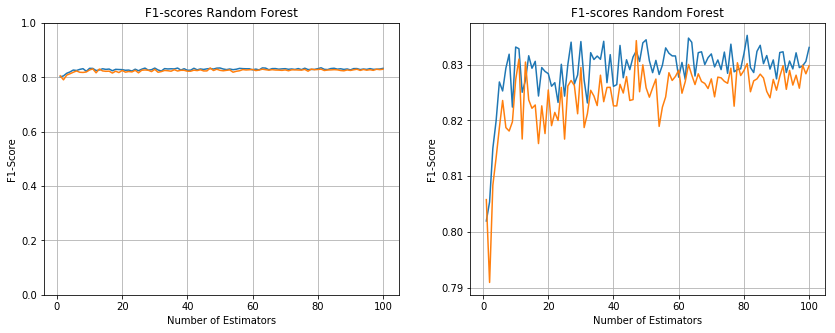

In [105]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.plot(range(1,total+1), scores_md5_train)
ax1.plot(range(1,total+1), scores_md5_test)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_title('F1-scores Random Forest')
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('F1-Score')

ax2 = fig.add_subplot(122)
ax2.plot(range(1,total+1), scores_md5_train)
ax2.plot(range(1,total+1), scores_md5_test)
ax2.grid()
ax2.set_title('F1-scores Random Forest')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('F1-Score')

plt.show()

---

In [106]:
scores_md20_train = []
scores_md20_test = []
total = 50
for n in range(total):
    model = skens.RandomForestClassifier(n_estimators=n+1, max_depth=20, n_jobs=-1)
    model.fit(X_train_3, y_train_3)
    y_pred_3 = model.predict(X_train_3)
    scores_md20_train.append(skmt.f1_score(y_train_3, y_pred_3))
    y_pred_3 = model.predict(X_test_3)
    scores_md20_test.append(skmt.f1_score(y_test_3, y_pred_3))
    loading(n, total)

[=================================================>] 100%

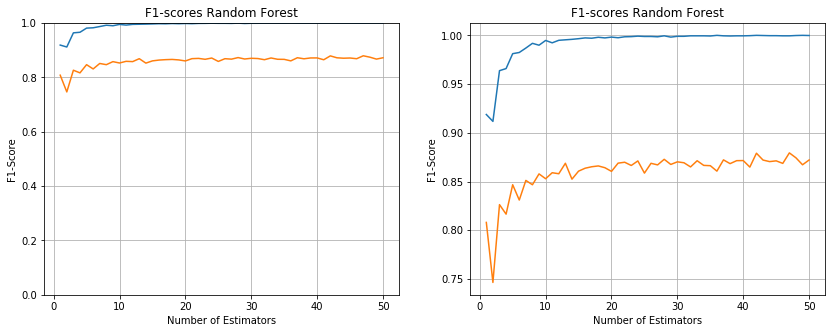

In [108]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.plot(range(1,total+1), scores_md20_train)
ax1.plot(range(1,total+1), scores_md20_test)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_title('F1-scores Random Forest')
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('F1-Score')

ax2 = fig.add_subplot(122)
ax2.plot(range(1,total+1), scores_md20_train)
ax2.plot(range(1,total+1), scores_md20_test)
ax2.grid()
ax2.set_title('F1-scores Random Forest')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('F1-Score')

plt.show()

En ninguno de los casos se aprecian mejoras significativas más allá de los 10 estimadores.

---
### 3.e

#### _AdaBoost_

In [114]:
# model = skens.AdaBoostClassifier(base_estimator=Tree(), n_estimators=)
scores_adaboost_train = []
scores_adaboost_test = []
total = 50
for n in range(total):
    model = skens.AdaBoostClassifier(base_estimator=sktr.DecisionTreeClassifier(max_depth=10), n_estimators=n+1)
    model.fit(X_train_3, y_train_3)
    y_pred_3 = model.predict(X_train_3)
    scores_adaboost_train.append(skmt.f1_score(y_train_3, y_pred_3))
    y_pred_3 = model.predict(X_test_3)
    scores_adaboost_test.append(skmt.f1_score(y_test_3, y_pred_3))
    loading(n, total)

[=================================================>] 100%

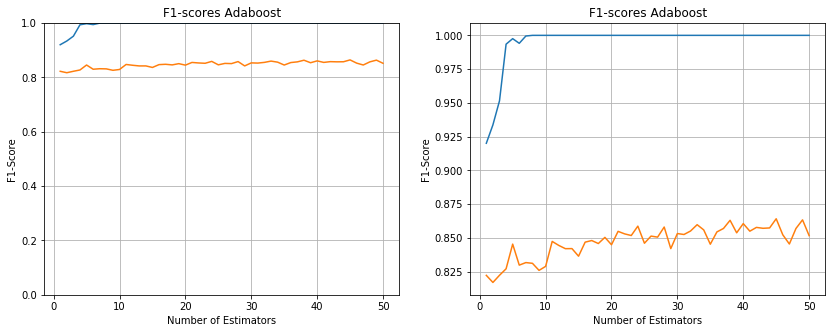

In [115]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.plot(range(1,total+1), scores_adaboost_train)
ax1.plot(range(1,total+1), scores_adaboost_test)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_title('F1-scores Adaboost')
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('F1-Score')

ax2 = fig.add_subplot(122)
ax2.plot(range(1,total+1), scores_adaboost_train)
ax2.plot(range(1,total+1), scores_adaboost_test)
ax2.grid()
ax2.set_title('F1-scores Adaboost')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('F1-Score')

plt.show()

---
### 3.f

#### Otra máquina

In [118]:
scores_xtrees_train = []
scores_xtrees_test = []
total = 50
for n in range(total):
    model = skens.ExtraTreesClassifier(n_estimators=n+1, max_depth=10)
    model.fit(X_train_3, y_train_3)
    y_pred_3 = model.predict(X_train_3)
    scores_xtrees_train.append(skmt.f1_score(y_train_3, y_pred_3))
    y_pred_3 = model.predict(X_test_3)
    scores_xtrees_test.append(skmt.f1_score(y_test_3, y_pred_3))
    loading(n, total)

[=================================================>] 100%

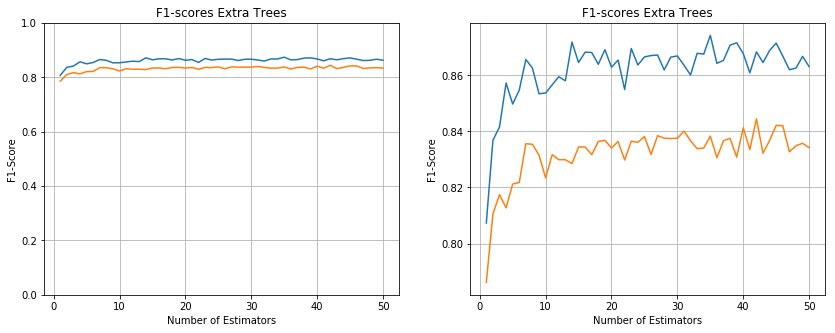

In [119]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.plot(range(1,total+1), scores_xtrees_train)
ax1.plot(range(1,total+1), scores_xtrees_test)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_title('F1-scores Extra Trees')
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('F1-Score')

ax2 = fig.add_subplot(122)
ax2.plot(range(1,total+1), scores_xtrees_train)
ax2.plot(range(1,total+1), scores_xtrees_test)
ax2.grid()
ax2.set_title('F1-scores Extra Trees')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('F1-Score')

plt.show()

---

In [123]:
scores_xtrees_train = []
scores_xtrees_test = []
total = 50
for n in range(total):
    model = skens.ExtraTreesClassifier(n_estimators=n+1, max_depth=20)
    model.fit(X_train_3, y_train_3)
    y_pred_3 = model.predict(X_train_3)
    scores_xtrees_train.append(skmt.f1_score(y_train_3, y_pred_3))
    y_pred_3 = model.predict(X_test_3)
    scores_xtrees_test.append(skmt.f1_score(y_test_3, y_pred_3))
    loading(n, total)

[=================================================>] 100%

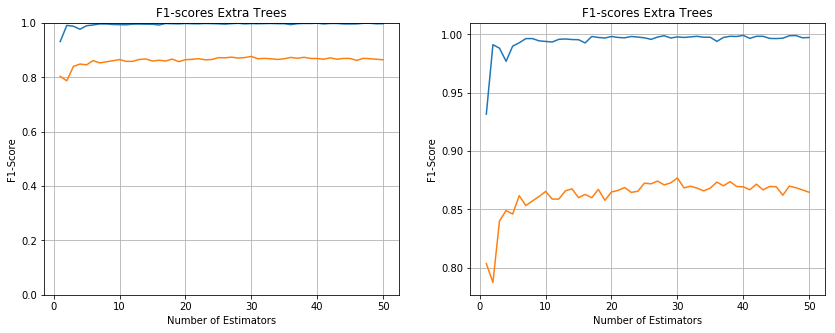

In [125]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.plot(range(1,total+1), scores_xtrees_train)
ax1.plot(range(1,total+1), scores_xtrees_test)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_title('F1-scores Extra Trees')
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('F1-Score')

ax2 = fig.add_subplot(122)
ax2.plot(range(1,total+1), scores_xtrees_train)
ax2.plot(range(1,total+1), scores_xtrees_test)
ax2.grid()
ax2.set_title('F1-scores Extra Trees')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('F1-Score')

plt.show()

---
### 3.g

#### Importancia de los Atributos

In [151]:
model = skens.RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)
model.fit(X_train_3, y_train_3)
feats = list(zip(model.feature_importances_, X_train_3.columns))
feats.sort(reverse=True)

print("Feature Importance Random Forest:")
for i, j in feats:
    print("{:>20}: {:10.09f}".format(j, i))

Feature Importance Random Forest:
             alcohol: 0.151073187
    volatile acidity: 0.113061196
             density: 0.104958972
         citric acid: 0.086826055
           chlorides: 0.085220170
total sulfur dioxide: 0.080367642
 free sulfur dioxide: 0.078971809
           sulphates: 0.077673190
      residual sugar: 0.074308250
                  pH: 0.073929093
       fixed acidity: 0.069270481
                type: 0.004339956


In [154]:
model = skens.AdaBoostClassifier(base_estimator=sktr.DecisionTreeClassifier(max_depth=20), n_estimators=20)
model.fit(X_train_3, y_train_3)
feats = list(zip(model.feature_importances_, X_train_3.columns))
feats.sort(reverse=True)

print("Feature Importance AdaBoost:")
for i, j in feats:
    print("{:>20}: {:10.09f}".format(j, i))

Feature Importance AdaBoost:
                  pH: 0.123280340
         citric acid: 0.117785371
total sulfur dioxide: 0.117088436
    volatile acidity: 0.111010815
           chlorides: 0.098865425
 free sulfur dioxide: 0.098251709
      residual sugar: 0.084123864
             alcohol: 0.075453012
       fixed acidity: 0.066878476
           sulphates: 0.057388058
             density: 0.049873850
                type: 0.000000644


---

---
## 4.- Lenguaje de Señas

---
### 4.a

#### Datos

In [3]:
def load_data():
    train = pd.read_csv('sign_mnist_train.csv')
    test = pd.read_csv('sign_mnist_test.csv')
    y_tr = train['label']
    x_tr = train.iloc[:,1:]
    y_t = test['label']
    x_t = test.iloc[:,1:]
    x_tr, x_v, y_tr, y_v = skms.train_test_split(x_tr, y_tr)
    return(x_tr,x_v,x_t,y_tr,y_v,y_t)

In [4]:
x_tr, x_v, x_t, y_tr, y_v, y_t = load_data()
print("Number of columns :", x_tr.shape[1])
print("Training size     :", x_tr.shape[0])
print("Validation size   :", x_v.shape[0])
print("Testing size      :", x_t.shape[0])

Number of columns : 784
Training size     : 20591
Validation size   : 6864
Testing size      : 7172


---
### 4.b

#### Escalar los datos

In [5]:
x_tr.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
6434,190,195,200,206,209,212,215,218,219,222,...,128,154,153,157,152,143,178,197,198,255
5489,103,109,118,125,129,132,136,139,143,144,...,67,30,0,15,9,8,2,0,0,0
21606,45,70,33,0,32,43,46,51,56,68,...,36,129,134,136,138,139,140,142,144,144
21528,138,142,145,148,148,149,151,153,154,156,...,187,186,186,186,186,186,186,185,185,185
12766,207,209,210,211,210,211,211,210,209,209,...,252,203,205,171,114,160,209,142,111,154


In [6]:
x_tr_255 = x_tr / 255
x_v_255 = x_v / 255
x_t_255 = x_t / 255
x_tr_255.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
6434,0.745098,0.764706,0.784314,0.807843,0.819608,0.831373,0.843137,0.854902,0.858824,0.870588,...,0.501961,0.603922,0.600000,0.615686,0.596078,0.560784,0.698039,0.772549,0.776471,1.000000
5489,0.403922,0.427451,0.462745,0.490196,0.505882,0.517647,0.533333,0.545098,0.560784,0.564706,...,0.262745,0.117647,0.000000,0.058824,0.035294,0.031373,0.007843,0.000000,0.000000,0.000000
21606,0.176471,0.274510,0.129412,0.000000,0.125490,0.168627,0.180392,0.200000,0.219608,0.266667,...,0.141176,0.505882,0.525490,0.533333,0.541176,0.545098,0.549020,0.556863,0.564706,0.564706
21528,0.541176,0.556863,0.568627,0.580392,0.580392,0.584314,0.592157,0.600000,0.603922,0.611765,...,0.733333,0.729412,0.729412,0.729412,0.729412,0.729412,0.729412,0.725490,0.725490,0.725490
12766,0.811765,0.819608,0.823529,0.827451,0.823529,0.827451,0.827451,0.823529,0.819608,0.819608,...,0.988235,0.796078,0.803922,0.670588,0.447059,0.627451,0.819608,0.556863,0.435294,0.603922


In [7]:
scaler = skpp.StandardScaler()
scaler.fit(pd.concat([x_tr, x_v]))
x_tr_ss = scaler.transform(x_tr)
x_v_ss = scaler.transform(x_v)
x_t_ss = scaler.transform(x_t)

Escalamos la data de dos maneras distintas, primero simplemente dividimos la data respecto a la intensidad maxima (efectivamente dejando todos los valores entre 0 y 1) y en el segundo caso estandarizamos la data usando un estandarizador usual. 

---
### 4.c

#### Neural Network

In [8]:
model1 = krms.Sequential()
model1.add(krly.Dense(30, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
model1.add(krly.Dense(30, kernel_initializer='uniform', activation='relu'))
model1.add(krly.Dense(25, kernel_initializer='uniform', activation='softmax'))
model1.compile(optimizer=kropt.SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model1.fit(
    x_tr_255.values,
    krnpu.to_categorical(y_tr),
    epochs=100,
    batch_size=128,
    verbose=1,
    validation_data=( x_v_255.values, krnpu.to_categorical(y_v) )
)

Train on 20591 samples, validate on 6864 samples
Epoch 1/100
20591/20591 [==============================] - 1s - loss: 3.2119 - acc: 0.0489 - val_loss: 3.2055 - val_acc: 0.0752
Epoch 2/100
20591/20591 [==============================] - 0s - loss: 3.1987 - acc: 0.0506 - val_loss: 3.1897 - val_acc: 0.0412
Epoch 3/100
20591/20591 [==============================] - 0s - loss: 3.1821 - acc: 0.0452 - val_loss: 3.1757 - val_acc: 0.0463
Epoch 4/100
20591/20591 [==============================] - 0s - loss: 3.1734 - acc: 0.0487 - val_loss: 3.1678 - val_acc: 0.0462
Epoch 5/100
20591/20591 [==============================] - 0s - loss: 3.1631 - acc: 0.0580 - val_loss: 3.1499 - val_acc: 0.0669
Epoch 6/100
20591/20591 [==============================] - 0s - loss: 3.0994 - acc: 0.0945 - val_loss: 2.9783 - val_acc: 0.1262
Epoch 7/100
20591/20591 [==============================] - 0s - loss: 2.8963 - acc: 0.1201 - val_loss: 2.7377 - val_acc: 0.1675
Epoch 8/100
20591/20591 [==============================

In [11]:
#Problemas con x_255?
eval_train_1 = model1.evaluate(x_tr_ss, krnpu.to_categorical(y_tr))
eval_val_1 = model1.evaluate(x_v_ss, krnpu.to_categorical(y_v))
eval_test_1 = model1.evaluate(x_t_ss, krnpu.to_categorical(y_t))

6560/7172 [==========================>...] - ETA: 0s

In [12]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_1[1]))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_1[1]))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_1[1]))

Error over Train Set      : 0.296828712
Error over Validation Set : 0.297931235
Error over Test Set       : 0.442136085


---

In [13]:
model2 = krms.Sequential()
model2.add(krly.Dense(30, input_dim=x_tr.shape[1], kernel_initializer='uniform', activation='relu'))
model2.add(krly.Dense(30, kernel_initializer='uniform', activation='relu'))
model2.add(krly.Dense(25, kernel_initializer='uniform', activation='softmax'))
model2.compile(optimizer=kropt.SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model2.fit(
    x_tr_ss,
    krnpu.to_categorical(y_tr),
    epochs=100,
    batch_size=128,
    verbose=1,
    validation_data=( x_v_ss, krnpu.to_categorical(y_v) )
)

Train on 20591 samples, validate on 6864 samples
Epoch 1/100
20591/20591 [==============================] - 1s - loss: 3.2065 - acc: 0.0791 - val_loss: 3.1875 - val_acc: 0.1244
Epoch 2/100
20591/20591 [==============================] - 1s - loss: 3.0671 - acc: 0.1192 - val_loss: 2.8227 - val_acc: 0.1492
Epoch 3/100
20591/20591 [==============================] - 0s - loss: 2.3444 - acc: 0.2599 - val_loss: 1.9117 - val_acc: 0.3680
Epoch 4/100
20591/20591 [==============================] - 0s - loss: 1.6763 - acc: 0.4362 - val_loss: 1.4318 - val_acc: 0.5095
Epoch 5/100
20591/20591 [==============================] - 0s - loss: 1.2573 - acc: 0.5727 - val_loss: 1.0676 - val_acc: 0.6349
Epoch 6/100
20591/20591 [==============================] - 0s - loss: 0.8983 - acc: 0.7046 - val_loss: 0.7430 - val_acc: 0.7685
Epoch 7/100
20591/20591 [==============================] - 0s - loss: 0.6222 - acc: 0.8043 - val_loss: 0.5405 - val_acc: 0.8253
Epoch 8/100
20591/20591 [==============================

In [15]:
eval_train_2 = model2.evaluate(x_tr_ss, krnpu.to_categorical(y_tr))
eval_val_2 = model2.evaluate(x_v_ss, krnpu.to_categorical(y_v))
eval_test_2 = model2.evaluate(x_t_ss, krnpu.to_categorical(y_t))

7136/7172 [============================>.] - ETA: 0s

In [16]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_2[1]))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_2[1]))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_2[1]))

Error over Train Set      : 0.000000000
Error over Validation Set : 0.000000000
Error over Test Set       : 0.314974902


Ya con la red neuronal de una sola capa oculta se comporta excelente sobre el validation set. Observamos que el comportamiento es relativamente mejor sobre la data estandarizada que sobre la data por intensidad maxima, sin embargo ambos tienen comportamiento casi perfecto sobre el test de validacion. De todas formas, al comparar con el error sobre el test set, vemos que aun hay mucho espacio para mejorar. 

In [17]:
reduc = skda.LinearDiscriminantAnalysis(n_components=200)
reduc.fit(x_tr_ss, y_tr)
x_tr_reduc = reduc.transform(x_tr_ss)
x_v_reduc = reduc.transform(x_v_ss)
x_t_reduc = reduc.transform(x_t_ss)

In [18]:
model3 = krms.Sequential()
model3.add(krly.Dense(30, input_dim=x_tr_reduc.shape[1], kernel_initializer='uniform', activation='relu'))
model3.add(krly.Dense(30, kernel_initializer='uniform', activation='relu'))
model3.add(krly.Dense(25, kernel_initializer='uniform', activation='softmax'))
model3.compile(optimizer=kropt.SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model3.fit(
    x_tr_reduc,
    krnpu.to_categorical(y_tr),
    epochs=100,
    batch_size=128,
    verbose=1,
    validation_data=( x_v_reduc, krnpu.to_categorical(y_v) )
)

Train on 20591 samples, validate on 6864 samples
Epoch 1/100
20591/20591 [==============================] - 0s - loss: 3.2092 - acc: 0.0695 - val_loss: 3.1985 - val_acc: 0.0975
Epoch 2/100
20591/20591 [==============================] - 0s - loss: 3.1753 - acc: 0.1445 - val_loss: 3.1231 - val_acc: 0.2335
Epoch 3/100
20591/20591 [==============================] - 0s - loss: 2.8159 - acc: 0.2677 - val_loss: 2.2781 - val_acc: 0.3505
Epoch 4/100
20591/20591 [==============================] - 0s - loss: 1.7972 - acc: 0.4753 - val_loss: 1.3797 - val_acc: 0.5900
Epoch 5/100
20591/20591 [==============================] - 0s - loss: 1.0357 - acc: 0.7247 - val_loss: 0.7272 - val_acc: 0.8226
Epoch 6/100
20591/20591 [==============================] - 0s - loss: 0.4775 - acc: 0.8930 - val_loss: 0.3343 - val_acc: 0.9238
Epoch 7/100
20591/20591 [==============================] - 0s - loss: 0.2274 - acc: 0.9505 - val_loss: 0.2028 - val_acc: 0.9508
Epoch 8/100
20591/20591 [==============================

In [20]:
eval_train_3 = model3.evaluate(x_tr_reduc, krnpu.to_categorical(y_tr))
eval_val_3 = model3.evaluate(x_v_reduc, krnpu.to_categorical(y_v))
eval_test_3 = model3.evaluate(x_t_reduc, krnpu.to_categorical(y_t))

7136/7172 [============================>.] - ETA: 0s

In [21]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_3[1]))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_3[1]))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_3[1]))

Error over Train Set      : 0.000388519
Error over Validation Set : 0.004516317
Error over Test Set       : 0.644311210


---

In [22]:
model4 = krms.Sequential()
model4.add(krly.Dense(50, input_dim=x_tr_ss.shape[1], kernel_regularizer=krrg.l2(0.0001), kernel_initializer='normal', activation='relu'))
model4.add(krly.Dense(25, kernel_initializer='uniform', activation='softmax'))
model4.compile(optimizer=kropt.SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model4.fit(
    x_tr_ss,
    krnpu.to_categorical(y_tr),
    epochs=100,
    batch_size=500,
    verbose=1,
    validation_data=( x_v_ss, krnpu.to_categorical(y_v) )
)

Train on 20591 samples, validate on 6864 samples
Epoch 1/100
20591/20591 [==============================] - 0s - loss: 2.9468 - acc: 0.1992 - val_loss: 2.6478 - val_acc: 0.2984
Epoch 2/100
20591/20591 [==============================] - 0s - loss: 2.3685 - acc: 0.3796 - val_loss: 2.0733 - val_acc: 0.4394
Epoch 3/100
20591/20591 [==============================] - 0s - loss: 1.8637 - acc: 0.5004 - val_loss: 1.6598 - val_acc: 0.5383
Epoch 4/100
20591/20591 [==============================] - 0s - loss: 1.5191 - acc: 0.5824 - val_loss: 1.3779 - val_acc: 0.6203
Epoch 5/100
20591/20591 [==============================] - 0s - loss: 1.2781 - acc: 0.6493 - val_loss: 1.1728 - val_acc: 0.6831
Epoch 6/100
20591/20591 [==============================] - 0s - loss: 1.0970 - acc: 0.7009 - val_loss: 1.0182 - val_acc: 0.7274
Epoch 7/100
20591/20591 [==============================] - 0s - loss: 0.9543 - acc: 0.7464 - val_loss: 0.8943 - val_acc: 0.7598
Epoch 8/100
20591/20591 [==============================

In [24]:
eval_train_4 = model4.evaluate(x_tr_ss, krnpu.to_categorical(y_tr))
eval_val_4 = model4.evaluate(x_v_ss, krnpu.to_categorical(y_v))
eval_test_4 = model4.evaluate(x_t_ss, krnpu.to_categorical(y_t))

6848/7172 [===========================>..] - ETA: 0s

In [25]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_4[1]))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_4[1]))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_4[1]))

Error over Train Set      : 0.000000000
Error over Validation Set : 0.000000000
Error over Test Set       : 0.227969883


---
### 4.d

#### Matriz de confusión

In [38]:
def plot_cnf_matrix(model, x, y):
    pred = model.predict_classes(x)
    cnf_matrix = skmt.confusion_matrix(y.values, pred)
    
    fig = plt.figure(figsize=(18,16))
    
    ax = fig.add_subplot(111)
    sbrn.heatmap(cnf_matrix, cmap="coolwarm_r", annot=True, linewidths=0.5, ax=ax, fmt="d", xticklabels=range(1,25), yticklabels=range(1,25))
    plt.title("Confussion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Real Class")

    plt.show()

---

7072/7172 [============================>.] - ETA: 0s

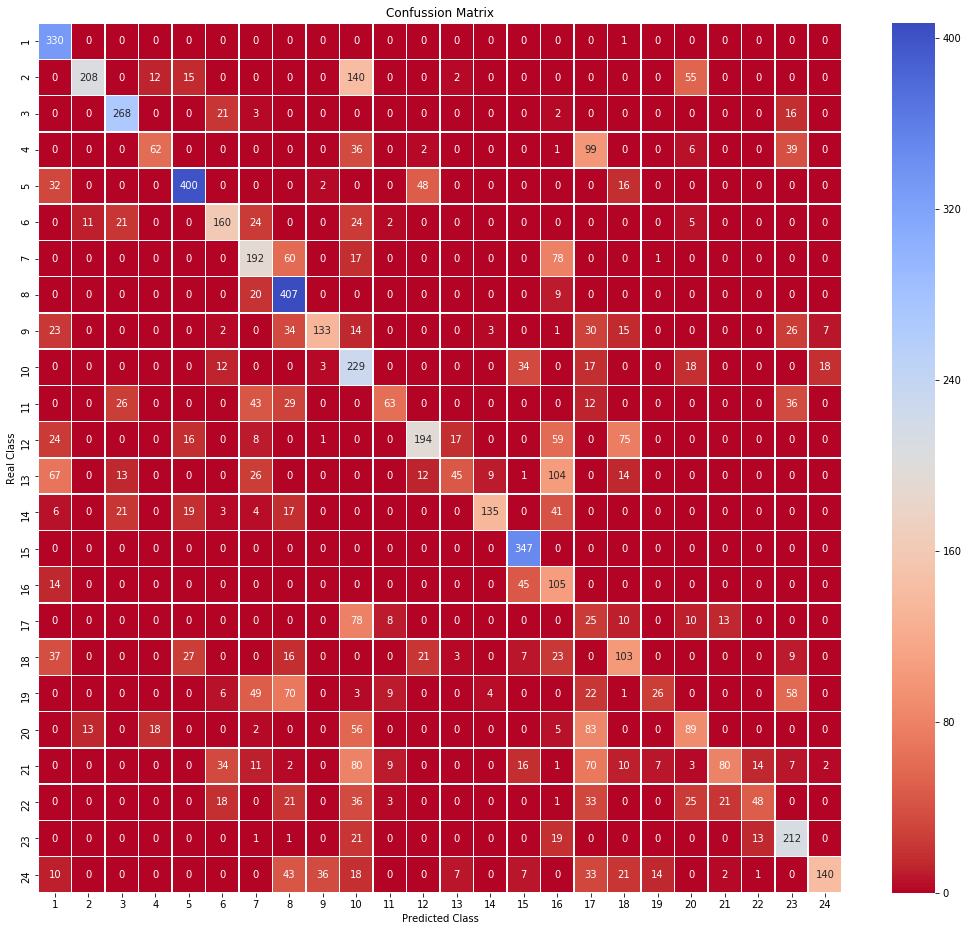

In [31]:
plot_cnf_matrix(model1, x_t_ss, y_t)

---

5824/7172 [=======================>......] - ETA: 0s

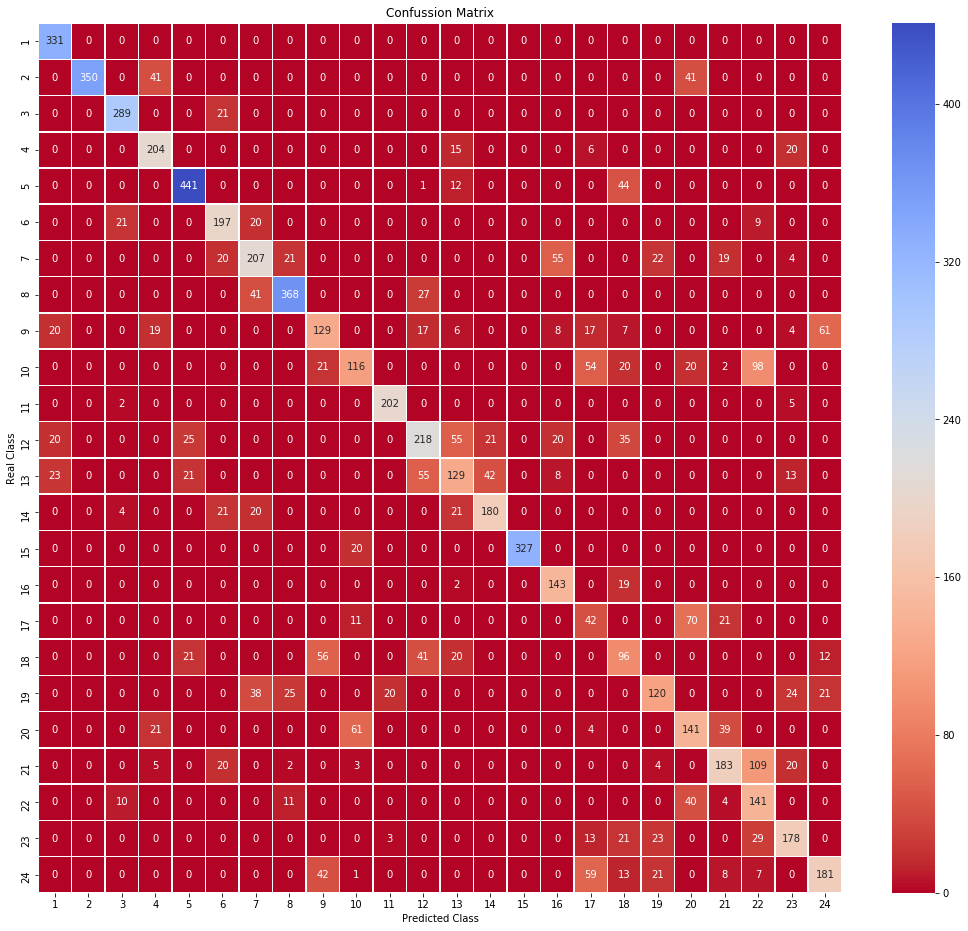

In [32]:
plot_cnf_matrix(model2, x_t_ss, y_t)

---

6048/7172 [========================>.....] - ETA: 0s

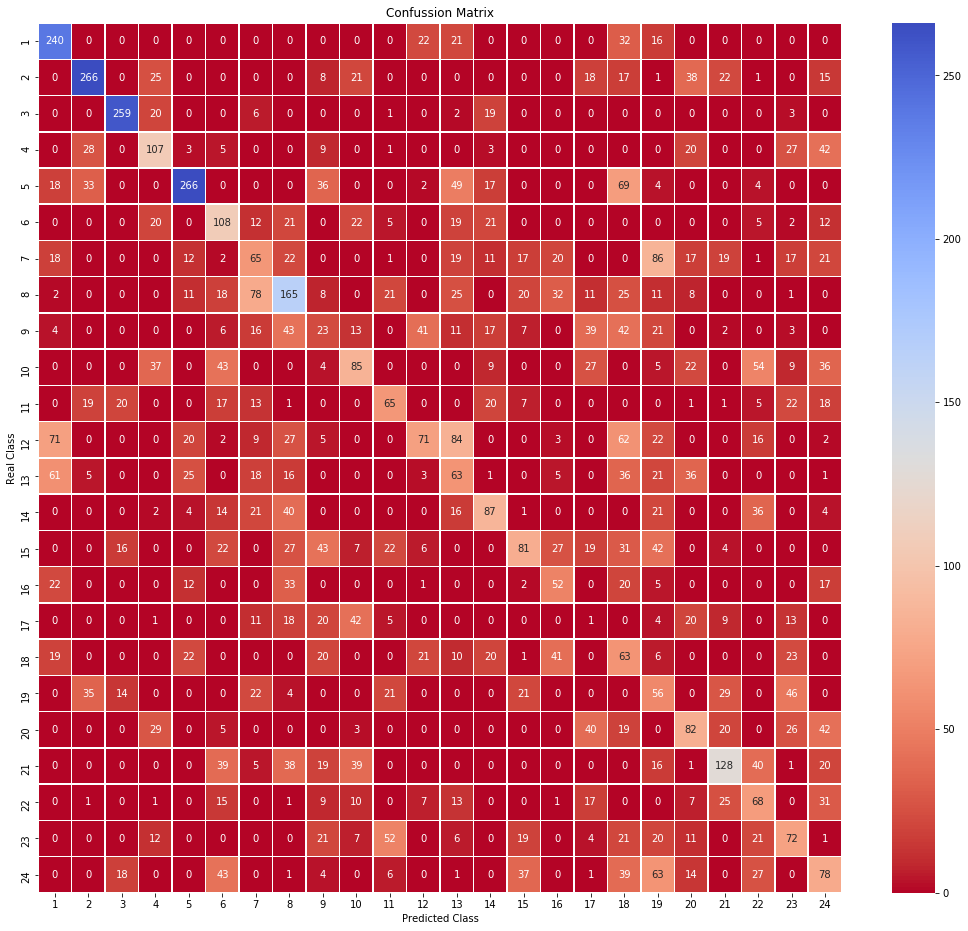

In [33]:
plot_cnf_matrix(model3, x_t_reduc, y_t)

---

5440/7172 [=====================>........] - ETA: 0s

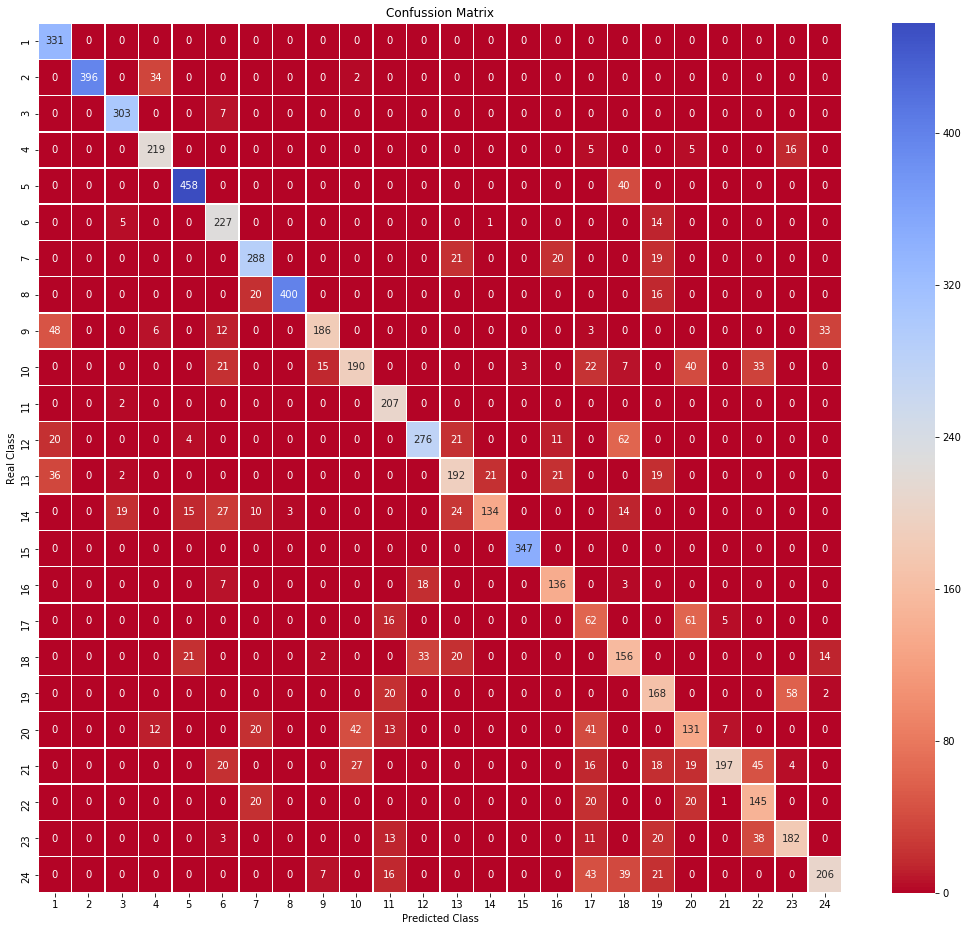

In [34]:
plot_cnf_matrix(model4, x_t_ss, y_t)

---

In [35]:
eval_train_4 = model4.evaluate(x_tr_ss, krnpu.to_categorical(y_tr))
eval_val_4 = model4.evaluate(x_v_ss, krnpu.to_categorical(y_v))
eval_test_4 = model4.evaluate(x_t_ss, krnpu.to_categorical(y_t))

6432/7172 [=========================>....] - ETA: 0s

In [36]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_4[1]))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_4[1]))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_4[1]))

Error over Train Set      : 0.000000000
Error over Validation Set : 0.000000000
Error over Test Set       : 0.227969883


---
### 4.e

#### SVM no lineal

In [41]:
def plot_cnf_matrix_SVR(model, x, y):
    pred = model.predict(x)
    cnf_matrix = skmt.confusion_matrix(y.values, pred)
    
    fig = plt.figure(figsize=(18,16))
    
    ax = fig.add_subplot(111)
    sbrn.heatmap(cnf_matrix, cmap="coolwarm_r", annot=True, linewidths=0.5, ax=ax, fmt="d", xticklabels=range(1,25), yticklabels=range(1,25))
    plt.title("Confussion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Real Class")

    plt.show()

In [20]:
model_SVR_5 = sksvm.SVR(max_iter=3000)
model_SVR_5.fit(x_tr,y_tr)

C:\Users\runo\Anaconda3\envs\machinelearning\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [21]:
eval_train_5 = model_SVR_5.score(x_tr, (y_tr))
eval_val_5 = model_SVR_5.score(x_v, (y_v))
eval_test_5 = model_SVR_5.score(x_t, (y_t))

In [22]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_5))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_5))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_5))

Error over Train Set      : 0.881470517
Error over Validation Set : 0.989070703
Error over Test Set       : 1.010216172


Como es de esperar, con la data sin transformar el modelo se comporta particularmenete mal sin estandarizar la data, de hecho limitamos el numero maximo de iteraciones para lograr obtener un resultado en tiempo razonable. Probaremos a continuacion con la data estandarizada.  

In [23]:
model_SVR_6 = sksvm.SVR(max_iter=3000)
model_SVR_6.fit(x_tr_ss,y_tr)

C:\Users\runo\Anaconda3\envs\machinelearning\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [24]:
eval_train_6 = model_SVR_6.score(x_tr_ss, (y_tr))
eval_val_6 = model_SVR_6.score(x_v_ss, (y_v))
eval_test_6 = model_SVR_6.score(x_t_ss, (y_t))

In [25]:
print("Error over Train Set      : {:10.9f}".format(1-eval_train_6))
print("Error over Validation Set : {:10.9f}".format(1-eval_val_6))
print("Error over Test Set       : {:10.9f}".format(1-eval_test_6))

Error over Train Set      : 0.323876800
Error over Validation Set : 0.338119196
Error over Test Set       : 0.405039120


Efectivamente la data estandarizada tiene un comportamiento mucho mejor que la data no estandarizada. 

---
### 4.f

#### Arbol de clasificación

In [45]:
tree_classifier_original = sktr.DecisionTreeClassifier()
tree_classifier_original.fit(x_tr,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [47]:
tree_classifier_standar = sktr.DecisionTreeClassifier()
tree_classifier_standar.fit(x_tr_ss,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [49]:
score_tree_original = tree_classifier_original.score(x_v,y_v)
score_tree_standar =tree_classifier_standar.score(x_v_ss,y_v)

In [51]:
print("Score over original data: {:10.9f}".format(score_tree_original))
print("Score over standarized data : {:10.9f}".format(score_tree_standar))

Score over original data: 0.881118881
Score over standarized data : 0.878642191


Vemos que para el arbol de clasificacione la estandarizacion de la data no tiene mucha influencia, sin embargo el arbol se comporta ligeramente mejor sobre la data original, asique trabajaremos sobre ella. Ahora realizaremos una busqueda de la profundidad maxima optima para el arbol.

In [58]:
scores_tree_depth = np.zeros(50)
for i in range(1,51):
    tree = sktr.DecisionTreeClassifier(max_depth=i)
    tree.fit(x_tr,y_tr)
    loading(i,50)
    scores_tree_depth[i-1] = tree.score(x_v, y_v)
max_depth_opt = 1 + np.argmax(scores_tree_depth)

[==================================================>] 1700%

In [60]:
print("Score over validation set : {:10.9f}".format(scores_tree_depth[max_depth_opt-1]))
print("Optimal Max Depth : {:10.9f}".format(max_depth_opt))

Score over validation set : 0.886509324
Optimal Max Depth : 50.000000000


No podemos asegurar haber alcanzado un optimo pues el valor podria seguir descendiendo para valores mayoes, sin embargo la busqueda para 50 valores ya es suficientemente larga. Para realizar busquedas mas exahustivas se deberia particionar la data y entrenar los arboles para sets de datos mas pequeños y luego validar los resultados para el set completo. 